# Advanced Reverse Image Search

I think you've gone through "[Getting Started with Reverse Image Search](./getting_started.ipynb)". Next, let's look at advanced content, including model selection and metrics reporting, performance optimization and stability improving, and finally deploying online service with FastAPI.

## Preparation

It's similar to [getting_started.ipynb](./getting_started.ipynb), first we need to read the data and then create the Milvus collection. If you have not downloaded the data and installed Milvus & Towhee, please refer to the [Getting Started Notebook](./getting_started.ipynb) Preparation section.

- Read image data

The dictionary `id_img` of id and image path, which is used to get the image corresponding to the id after searching. And `lable_ids` is a list of all ids with the same label, which is used for accuracy metric.

In [1]:
import pandas as pd

df = pd.read_csv('reverse_image_search.csv')

id_img = df.set_index('id')['path'].to_dict()
label_ids = {}
for label in set(df['label']):
    label_ids[label] = list(df[df['label']==label].id)

- Create Milvus collection and build index

Then define a function to create Milvus collection and build `IVF_FLAT` index for it.

In [2]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

# create reverse_image_search collection and build index
def create_milvus_collection(collection_name, dim):
    connections.connect(host='127.0.0.1', port='19530')
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    fields = [
    FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='reverse image search')
    collection = Collection(name=collection_name, schema=schema)

    # create IVF_FLAT index for collection.
    index_params = {
        'metric_type':'L2',
        'index_type':"IVF_FLAT",
        'params':{"nlist":2048}
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection

## Optimization and Metric Report

Here we will try various models and methods to search for pictures, such as comparing `ResNet` and `VGG` models, as well as the popular transformer model `vit`, or we can first do object detection on image, and then search for object target on images.

You can see that there is no code for `to_milvus` and `milvus_search` , instead [`ann_insert`](https://towhee.io/towhee/ann-insert) and [`ann_search`](https://towhee.io/towhee/ann-search) are used. In fact, both methods are supported in Towhee, but the ann method will integrate more indexes, and will integrate **Faiss** and **Hnswlib** in the future, as long as you specify ann_index.

**Note**: The following are all run on a GPU (GeForce GTX 1660), which the `torch.cuda.is_available()` is `True`, you can also run the following code on CPU, but it is very slow (10 times lower).

In [3]:
import torch
torch.cuda.is_available()

True

### **Mulit Model: ResNet&VGG**

We will try to run four models: `VGG16`, `VGG19`, `ResNet50` and `ResNet101`, then to compare the **mean hit ratio** and **mean average precision**.

- mean hit ratio

Divide the number of result hits with the number of ground-truth.

- mean average precision

Compares the ground-truth topk to the result box.


In [4]:
%%time
import towhee

model_dim = {
    'vgg16': 4096,
    'vgg19': 4096,
    'resnet50': 2048,
    'resnet101': 2048
}

for model in model_dim:
    collection = create_milvus_collection(model, model_dim[model])
    milvus_collection = towhee.connectors.milvus(uri=f'tcp://127.0.0.1:19530/{model}')
        
    with milvus_collection:
        ( towhee.read_csv('reverse_image_search.csv')
                .runas_op['id', 'id'](func=lambda x: int(x))
                .image_decode['path', 'img']()
                .image_embedding.timm['img', 'vec'](model_name=model)
                .tensor_normalize['vec', 'vec']()
                .batch(100)
                .ann_insert[('id','vec'), 'res'](ann_index=milvus_collection)
                .run()
        )
        
        ( towhee.glob['path']('./extracted_test/*/*.JPEG')
                .image_decode['path', 'img']()
                .image_embedding.timm['img', 'vec'](model_name=model)
                .tensor_normalize['vec', 'vec']()
                .runas_op['path', 'ground_truth'](func=lambda path: label_ids[path.split('/')[-2]])
                .ann_search['vec', 'result'](ann_index=milvus_collection)
                .runas_op['result', 'result'](func=lambda res: [x.id for x in res])
                .with_metrics(['mean_hit_ratio', 'mean_average_precision'])
                .evaluate['ground_truth', 'result'](model)
                .report()
        )

,mean_hit_ratio,mean_average_precision
vgg16,0.652,0.849296


,mean_hit_ratio,mean_average_precision
vgg19,0.682,0.873363


,mean_hit_ratio,mean_average_precision
resnet50,0.781,0.917373


,mean_hit_ratio,mean_average_precision
resnet101,0.937,0.973761


CPU times: user 10min 11s, sys: 37.6 s, total: 10min 48s
Wall time: 3min 10s


### **Vision Transformer**

Next, try to run the popular transformer models such as ViT, first initialize the model and then define the `vit_embedding` function to generate the embedding vector of the image. This function can be added to the towhee pipeline using `runas_op`, then insert and search the data, finally report its accuracy metric.

In [5]:
%%time
from transformers import ViTFeatureExtractor, ViTModel

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


def vit_embedding(img):
    img = img.cv2_to_rgb()
    inputs = feature_extractor(img, return_tensors="pt")
    outputs = model(inputs['pixel_values'].to(device))
    return outputs.pooler_output.detach().cpu().numpy().flatten()

collection = create_milvus_collection('huggingface_vit', 768)
milvus_collection = towhee.connectors.milvus(uri=f'tcp://127.0.0.1:19530/huggingface_vit')

with milvus_collection:
    ( towhee.read_csv('reverse_image_search.csv')
            .runas_op['id', 'id'](func=lambda x: int(x))
            .image_decode['path', 'img']()
            .runas_op['img', 'vec'](func=vit_embedding)
            .tensor_normalize['vec', 'vec']()
            .batch(100)
            .ann_insert[('id','vec'), 'res'](ann_index=milvus_collection)
            .run()
    )

    ( towhee.glob['path']('./extracted_test/*/*.JPEG')
            .image_decode['path', 'img']()
            .runas_op['img', 'vec'](func=vit_embedding)
            .tensor_normalize['vec', 'vec']()
            .runas_op['path', 'ground_truth'](func=lambda path: label_ids[path.split('/')[-2]])
            .ann_search['vec', 'result'](ann_index=milvus_collection)
            .runas_op['result', 'result'](func=lambda res: [x.id for x in res])
            .with_metrics(['mean_hit_ratio', 'mean_average_precision'])
            .evaluate['ground_truth', 'result']('huggingface_vit')
            .report()
    )

,mean_hit_ratio,mean_average_precision
huggingface_vit,0.836,0.948029


CPU times: user 2min 13s, sys: 10.2 s, total: 2min 23s
Wall time: 50 s


### **Object Detection with YOLO**

Finally, we can try to add object detection for reverse image search, i.e. use YOLOv5 to get the object of the image before image feature vector extraction, and then use that object to represent the image data for insertion and search.

`get_object` function is used to get the image of the largest object detected by YoLov5, or the image itself if there is no object, then insert the resulting image into Milvus, and finally do the search. Object detection is very common in product search.

In [6]:
%%time
collection = create_milvus_collection('yolov5', 2048)
milvus_collection = towhee.connectors.milvus(uri='tcp://127.0.0.1:19530/yolov5')

def get_object(img, boxes):
    if len(boxes) == 0:
        return img
    max_area = 0
    for box in boxes:
        x1, y1, x2, y2 = box
        area = (x2-x1)*(y2-y1)
        if area > max_area:
            max_area = area
            max_img = img[y1:y2,x1:x2,:]
    return max_img

with milvus_collection:
    ( towhee.read_csv('reverse_image_search.csv')
            .runas_op['id', 'id'](func=lambda x: int(x))
            .image_decode['path', 'img']()
            .object_detection.yolov5['img', ('boxes', 'class', 'score')]()
            .runas_op[('img', 'boxes'), 'object'](func=get_object)
            .image_embedding.timm['object', 'vec'](model_name='resnet101')
            .tensor_normalize['vec', 'vec']()
            .batch(100)
            .ann_insert[('id','vec'), 'res'](ann_index=milvus_collection)
            .run()
    )

    ( towhee.glob['path']('./extracted_test/*/*.JPEG')
            .image_decode['path', 'img']()
            .object_detection.yolov5['img', ('boxes', 'class', 'score')]()
            .runas_op[('img', 'boxes'), 'object'](func=get_object)
            .image_embedding.timm['object', 'vec'](model_name='resnet101')
            .tensor_normalize['vec', 'vec']()
            .runas_op['path', 'ground_truth'](func=lambda path: label_ids[path.split('/')[-2]])
            .ann_search['vec', 'result'](ann_index=milvus_collection)
            .runas_op['result', 'result'](func=lambda res: [x.id for x in res])
            .with_metrics(['mean_hit_ratio', 'mean_average_precision'])
            .evaluate['ground_truth', 'result']('yolov5-resnet101')
            .report()
    )

,mean_hit_ratio,mean_average_precision
yolov5-resnet101,0.698,0.849805


CPU times: user 2min 26s, sys: 1.77 s, total: 2min 28s
Wall time: 1min 2s


Through the comparison of the above three groups, we found that the `resnet101` model performed the best in this dataset, so we can select `resnet101` model for the following serveice. I think this is also affected by the dataset, and different datasets will perform differently. You can use your own datasets for selection and comparison.

| Models           | Mean Hit Ratio | Mean Average Precision |
| ---------------- | -------------- | ---------------------- |
| VGG16            |     0.652      |         0.849          |
| VGG19            |     0.682      |         0.873          |
| ResNet50         |     0.781      |         0.917          |
| Resnet101        |     **0.937**      |         **0.974**          |
| ViT              |     0.836      |         0.948          |
| YOLOv5-Resnet101 |     0.698      |         0.850          |

## Stable and Efficient

If there is a large scale of data in the image search system, how can optimize the performance? How to ensure the stability of the system? Towhee supports - Parallel execution to improve performance, and also has `exception_safe` to collect error information to ensure system stability.

### Parallel Execution to Improve Performance

`set_parallel` will set the parallelism and improve performance, there will run a comparison with ViT model. It can be seen that the execution speed below is nearly three times faster than before. And note that please clean up the GPU cache before runing with parallel.

In [7]:
%%time
collection = create_milvus_collection('test_resnet101', 2048)
milvus_collection = towhee.connectors.milvus(uri='tcp://127.0.0.1:19530/test_resnet101')

with milvus_collection:
    ( towhee.read_csv('reverse_image_search.csv')
            .runas_op['id', 'id'](func=lambda x: int(x))
            .image_decode['path', 'img']()
            .image_embedding.timm['img', 'vec'](model_name='resnet101')
            .tensor_normalize['vec', 'vec']()
            .batch(100)
            .ann_insert[('id','vec'), 'res'](ann_index=milvus_collection)
            .run()
    )

CPU times: user 2min 11s, sys: 5.98 s, total: 2min 17s
Wall time: 37.7 s


In [8]:
%%time
collection_parallel = create_milvus_collection('test_resnet101_parallel', 2048)
milvus_collection_parallel = towhee.connectors.milvus(uri='tcp://127.0.0.1:19530/test_resnet101_parallel')

with milvus_collection_parallel:
    ( towhee.read_csv('reverse_image_search.csv')
            .set_parallel(3)
            .runas_op['id', 'id'](func=lambda x: int(x))
            .image_decode['path', 'img']()
            .image_embedding.timm['img', 'vec'](model_name='resnet101')
            .tensor_normalize['vec', 'vec']()
            .batch(100)
            .ann_insert[('id','vec'), 'res'](ann_index=milvus_collection_parallel)
            .run()
    )

CPU times: user 45.2 s, sys: 7.8 s, total: 53 s
Wall time: 25 s


### Expetion Safe and Drop Empty

When we have large-scale image data, there may be bad data that will cause errors, and `exception_safe` will report an exception but not abort the operation, then return to Empty. Finally use `drop_empty` to clear the empty data and continue to run the pipeline.

2022-05-07 19:46:38,228 - 139885059117632 - image_decode_cv2.py-image_decode_cv2:64 - ERROR: Read image ./exception/test.JPEG failed, /home/zilliz_support/workspace/shiyu/examples/image/reverse_image_search/test/exception/test.JPEG


img,result_img
,
,
,

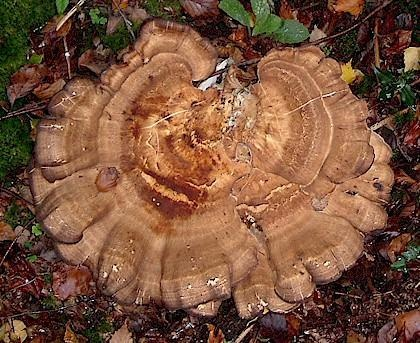
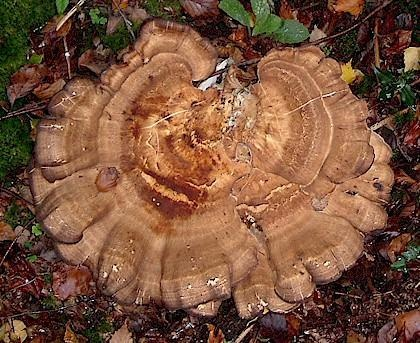
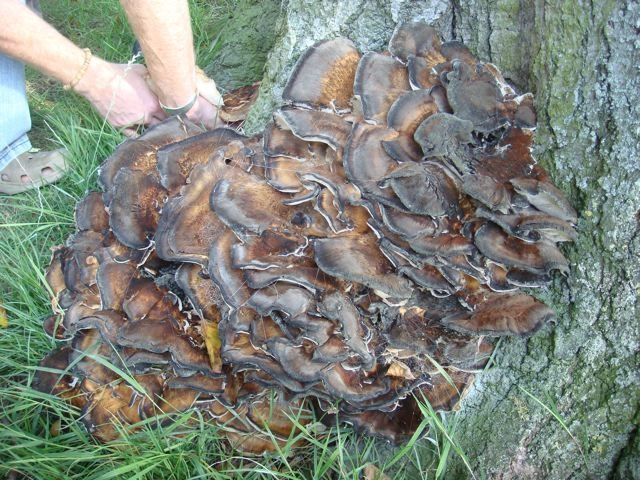
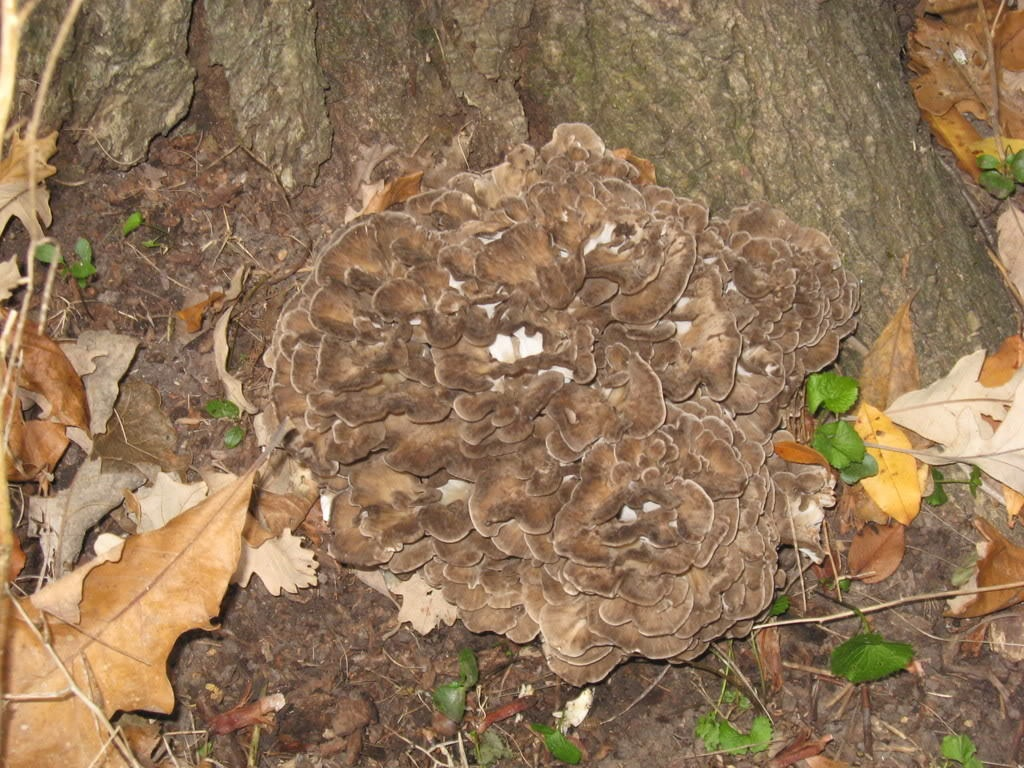
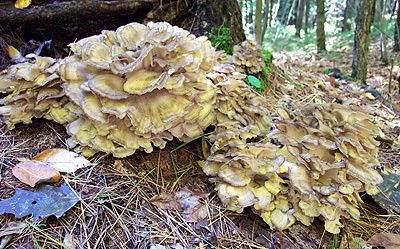
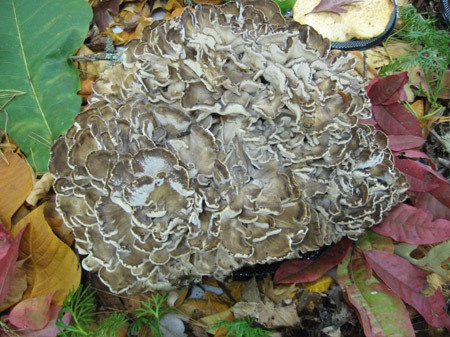
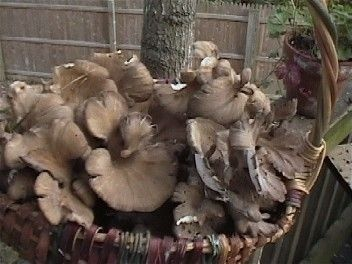
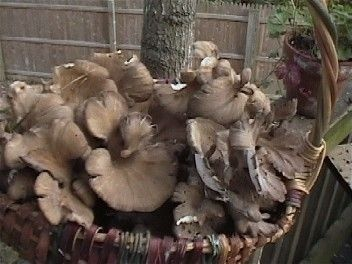
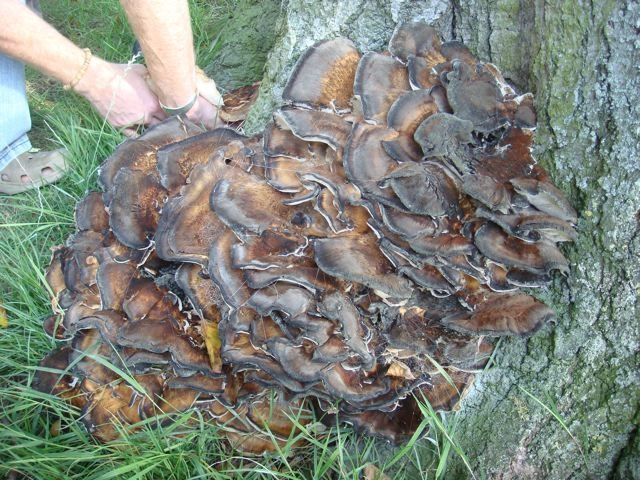
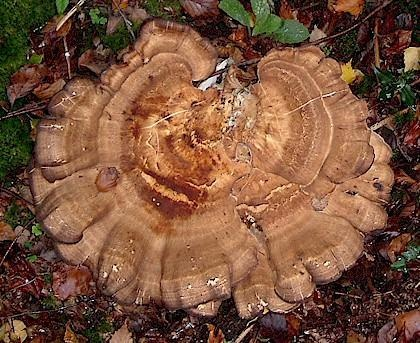
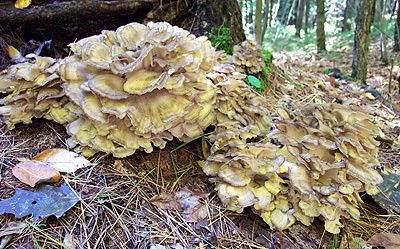
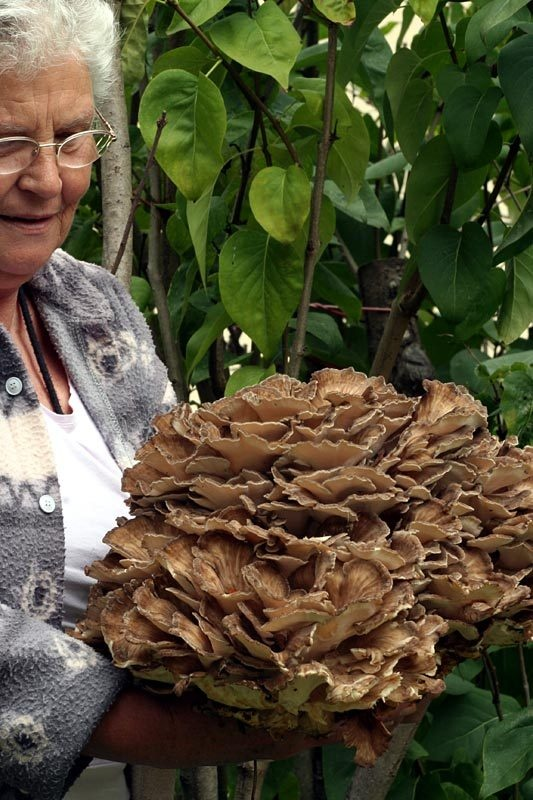
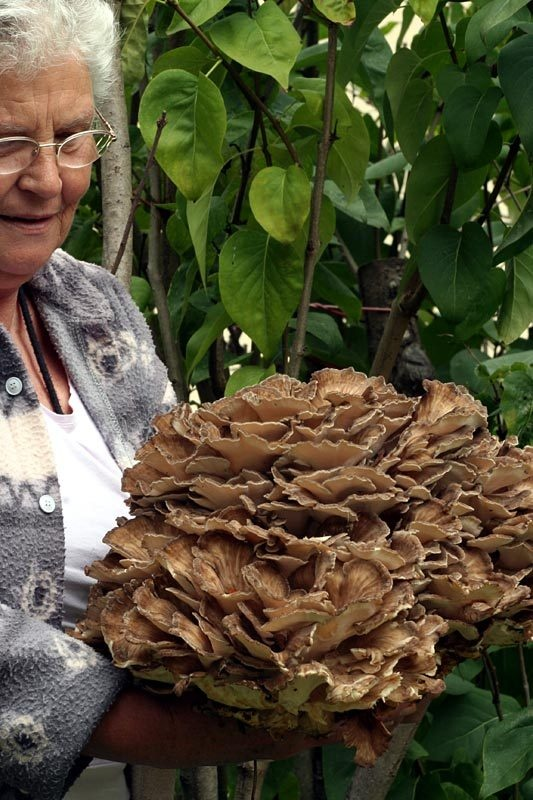
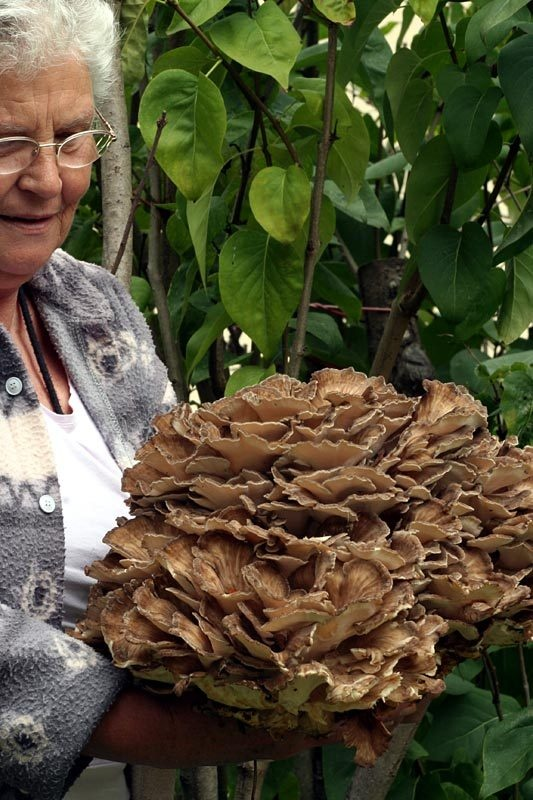
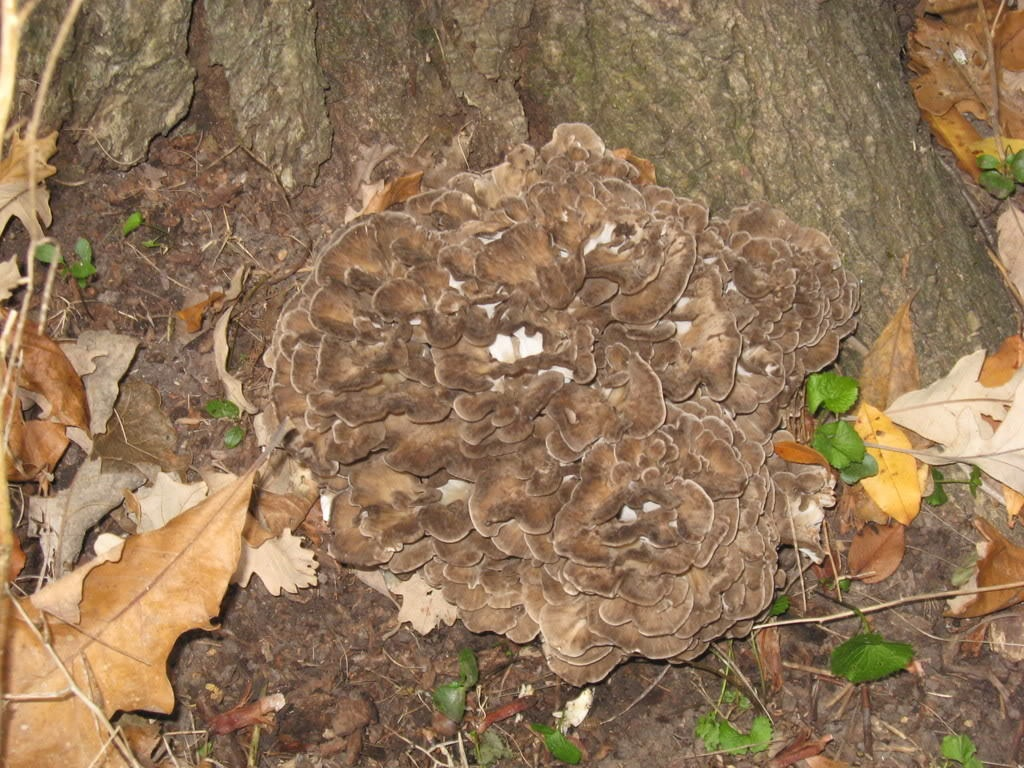
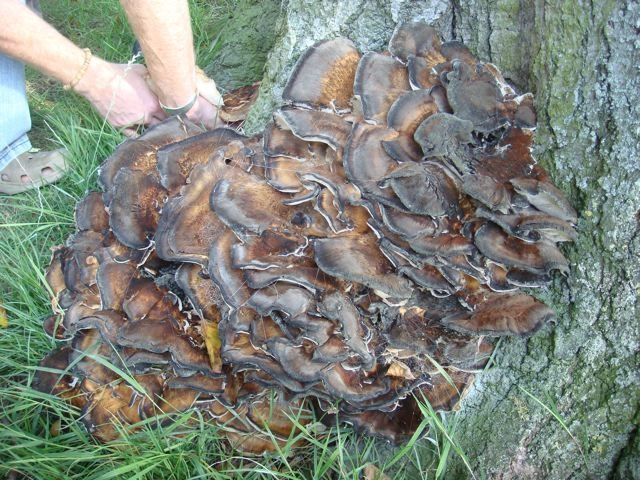
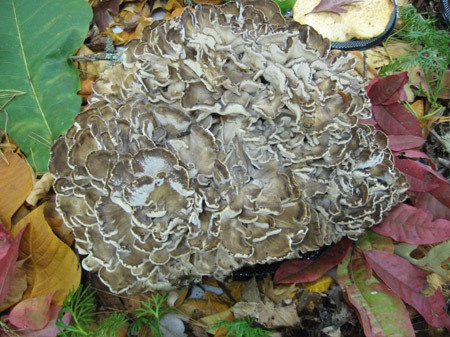
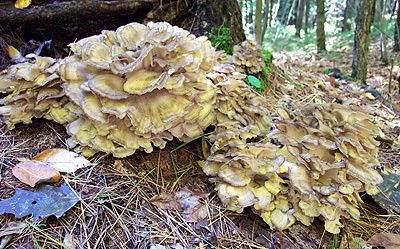

In [9]:
import cv2
from towhee._types.image import Image

def get_result_imgs(results):
    imgs = []
    for re in results:
        path = id_img[re.id]
        imgs.append(Image(cv2.imread(path), 'BGR'))
    return imgs

milvus_collection = towhee.connectors.milvus(uri='tcp://127.0.0.1:19530/resnet101')

with milvus_collection:
    (
  towhee.glob['path']('./exception/*.JPEG')
        .exception_safe()
        .image_decode['path', 'img']()
        .image_embedding.timm['img', 'vec'](model_name='resnet101')
        .tensor_normalize['vec', 'vec']()
        .ann_search['vec', 'result'](ann_index=milvus_collection, limit=5)
        .runas_op['result', 'result_img'](func=get_result_imgs)
        .drop_empty()
        .select['img', 'result_img']()
        .show()
    )

## Deploy with FastAPI

The `server` method of `towhee.api` supports generating FastAPI services from towhee pipelines. And `as_function` can convert it into a function which is used for gradio functions in [getting started notebook](./getting_started.ipynb).

### Insert Image Data

In [10]:
from fastapi import FastAPI
app = FastAPI()
milvus_collection = towhee.connectors.milvus(uri='tcp://127.0.0.1:19530/resnet101')

@towhee.register(name='get_path_id')
def get_path_id(path):
    timestamp = int(time.time()*10000)
    id_img[timestamp] = path
    return timestamp

with towhee.api['file']() as api:
    app_insert = (
        api.image_load['file', 'img']()
        .save_image['img', 'path'](dir='tmp/images')
        .get_path_id['path', 'id']()
        .image_embedding.timm['img', 'vec'](model_name='resnet101')
        .tensor_normalize['vec', 'vec']()
        .ann_insert[('id', 'vec'), 'res'](ann_index=milvus_collection)
        .select['id', 'path']()
        .serve('/insert', app)
    )

### Search Similar Image

In [11]:
with towhee.api['file']() as api:
    app_search = (
        api.image_load['file', 'img']()
        .image_embedding.timm['img', 'vec'](model_name='resnet101')
        .tensor_normalize['vec', 'vec']()
        .ann_search['vec', 'result'](ann_index=milvus_collection)
        .runas_op['result', 'res_file'](func=lambda res: [id_img[x.id] for x in res])
        .select['res_file']()
        .serve('/search', app)
    )

### Count Numbers

In [12]:
with towhee.api() as api:
    app_count = (
        api.map(lambda _: milvus_collection.count())
        .serve('/count', app)
        )

### Start Server

Finally to start FastAPI, there are three services `/insert`, `/search` and `/count`, you can run the following commands to test:

```bash
# upload an image and search
$ curl -X POST "http://0.0.0.0:8000/search"  --data-binary @extracted_test/n01443537/n01443537_3883.JPEG -H 'Content-Type: image/jpeg'
# upload an image and insert
$ curl -X POST "http://0.0.0.0:8000/insert"  --data-binary @extracted_test/n01443537/n01443537_3883.JPEG -H 'Content-Type: image/jpeg'
# count the collection
$ curl -X POST "http://0.0.0.0:8000/count"
```

In [ ]:
import uvicorn
import nest_asyncio

nest_asyncio.apply()
uvicorn.run(app=app, host='0.0.0.0', port=8000)

INFO:     Started server process [15389]
2022-05-07 19:47:02,020 - 139885059117632 - server.py-server:64 - INFO: Started server process [15389]
INFO:     Waiting for application startup.
2022-05-07 19:47:02,021 - 139885059117632 - on.py-on:26 - INFO: Waiting for application startup.
INFO:     Application startup complete.
2022-05-07 19:47:02,023 - 139885059117632 - on.py-on:38 - INFO: Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
2022-05-07 19:47:02,024 - 139885059117632 - server.py-server:199 - INFO: Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:39040 - "POST /count HTTP/1.1" 200 OK
INFO:     127.0.0.1:39440 - "POST /search HTTP/1.1" 200 OK
